In [90]:
import numpy as np
import pandas as pd
import os
import sys

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.timeseries import LombScargle

# import tkinter
import matplotlib
# %matplotlib inline
# matplotlib.use('TkAgg')
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

import seaborn as sns
sns.set(style="darkgrid")

from scipy.stats import gaussian_kde
from IPython.display import display

In [91]:
data_dir = './data/'
object = 'J1503.7-5801'
ebin_number = 0

filename_events = data_dir+object+'/'+'events_4FGL_'+object+'_e'+str(ebin_number)+'.txt'
filename_out7   = data_dir+object+'/'+'4FGL_'+object+'_out7_rois.txt'
filename_out10  = data_dir+object+'/'+'out10_lc_e'+str(ebin_number)+'.txt'


In [92]:
'''
out10 file
day binning
'''

out10 = np.loadtxt(filename_out10)
print('out10 fileshape: '+str(out10.shape))

time_bin_start = out10[:,0]
time_bin_end   = time_bin_start + out10[:,1]

counts_bin     = out10[:,2]
exposure_bin   = out10[:,4]

total_counts_out10 = np.sum(counts_bin)
print('Total counts from out10: '+str(int(total_counts_out10)))

## sampling array
sample_rate = 5
sample_offset = 0
time_bin_start_samp = time_bin_start[sample_offset:-sample_rate:sample_rate]
time_bin_end_samp = time_bin_end[sample_offset+sample_rate-1::sample_rate]
num_samp_bins = len(time_bin_start_samp)

time_bin_samp_mets = (time_bin_start_samp + time_bin_end_samp)/2
time_bin_samp_days = time_bin_samp_mets/(60*60*24) + 2451910.5
time_bin_samp_days-= time_bin_samp_days.min()
# print(time_bin_start_samp[:5])
# print(time_bin_end_samp[:5])

counts_bin_samp = np.zeros(num_samp_bins)
exposure_bin_samp = np.zeros(num_samp_bins)
for ii in range(0,num_samp_bins):
    samp_arr = np.logical_and(time_bin_start>=time_bin_start_samp[ii], time_bin_end<=time_bin_end_samp[ii])
    counts_bin_samp[ii] = np.sum(counts_bin[samp_arr])
    exposure_bin_samp[ii] = np.sum(exposure_bin[samp_arr])
print('Number condensed bins: '+str(len(time_bin_start_samp)))

## renormalize exposure to counts
counts_bin_samp_avg = np.mean(counts_bin_samp[ii])
exposure_bin_samp_avg = np.mean(exposure_bin_samp)

# exposure_bin_samp*= counts_bin_samp_avg/exposure_bin_samp_avg

# print(counts_bin_samp[:5])
# print(exposure_bin_samp[:5])

out10 fileshape: (4047, 5)
Total counts from out10: 146189
Number condensed bins: 809


In [93]:
'''
out7 file
'''

out7 = np.loadtxt(filename_out7)
print('out7 fileshape: '+str(out7.shape))

bin_energy = out7[ebin_number,1]
bin_roi    = out7[ebin_number,2]
print('Bin Energy: '+str(bin_energy))
print('Bin ROI: '+str(bin_roi))

out7 fileshape: (20, 8)
Bin Energy: 125.892541179
Bin ROI: 2.81


In [94]:
'''
EVENTS FILE
0 - Arrival time (METS)
1 - energy (MeV)
2 - RA
3 - DEC
4 - Long
5 - Lat
6 - Theta (instrumental)
7 - SkyCoordinate (instrumental)
8 - Zenith angle (earth)
9 - Earth azimuth (Earth)
'''

read_in = np.loadtxt(filename_events)

time_mets = read_in[:,0]
total_events = len(time_mets)

## time in days
time = read_in[:,0]/(60*60*24) + 2451910.5
time-= np.amin(time)

energy = read_in[:,1]

In [95]:
print('Data shape: '+str(read_in.shape))
print('First Event: '+str(read_in[0]))

Data shape: (146189, 10)
First Event: [ 2.39559656e+08  1.25124000e+02  2.25759000e+02 -5.54382000e+01
  3.20901000e+02  2.77441000e+00  6.53531000e+01  1.03160000e+02
  3.06869000e+01  1.90100000e+02]


In [96]:
theta1 = read_in[:,6]
theta2 = read_in[:,7]

theta_x = theta1*np.cos(theta2)
theta_y = theta1*np.sin(theta2)

print(theta1, theta2)


[65.3531  20.9619  56.7768  ...  7.27921  7.48054 15.3238 ] [103.16  348.724 219.742 ... 193.166 179.653 121.651]


In [97]:
RA_obj = 15 *u.hour + 3.7 *u.min
DE_obj = -58.01 *u.deg

c_obj = SkyCoord(ra=RA_obj, dec=DE_obj)
print(c_obj)

<SkyCoord (ICRS): (ra, dec) in deg
    (225.925, -58.01)>


In [98]:
RA = read_in[:,2] *u.deg
DE = read_in[:,3] *u.deg

c_photon = SkyCoord(ra=RA, dec=DE)
c_photon_dra, c_photon_dde = c_photon.spherical_offsets_to(c_obj)

dRA = c_photon_dra.deg # relative RA
dDE = c_photon_dde.deg # relative DE

c_sep = c_photon.separation(c_obj)
angle_from_obj = c_sep.deg
max_angle_from_obj = np.amax(angle_from_obj)
print('Max angular distance: '+str(round(max_angle_from_obj,2)))

Max angular distance: 2.83


In [99]:
''' Making pandas DataFrame'''

d = {'time_mets':time_mets, 'time_days':time, 'dRA':dRA, 'dDE':dDE, 'theta1':theta_x, 'theta2':theta2_y, 'energy':energy, 
     'angle_from_obj':angle_from_obj}
df = pd.DataFrame(data=d)
display(df.head(10))
# print(df.loc[:10])

,time_mets,time_days,dRA,dDE,theta1,theta2,energy,angle_from_obj
0,2.395597e+08,0.000000,0.088031,-2.571905,65.35310,103.16000,125.124,2.573410
1,2.395657e+08,0.070220,-2.122640,-0.322816,20.96190,348.72400,138.224,2.147035
2,2.396100e+08,0.582576,2.287234,0.724123,56.77680,219.74200,124.786,2.399065
3,2.396110e+08,0.594432,-1.286040,0.407580,8.63747,203.11700,109.773,1.349071
4,2.396116e+08,0.600909,0.532586,1.513374,22.21290,357.83300,145.623,1.604333
5,2.396219e+08,0.720944,-1.194954,0.262085,36.01020,204.22900,149.939,1.223354
6,2.396227e+08,0.729605,-2.612763,0.593609,2.14300,313.14500,117.458,2.679302
7,2.396229e+08,0.731795,0.659894,1.908896,14.15150,1.89976,121.411,2.019698
8,2.396231e+08,0.734358,-1.975346,1.662875,23.01480,356.87700,104.487,2.581869
9,2.396237e+08,0.741670,0.506974,0.053107,57.32260,322.21700,101.687,0.509748


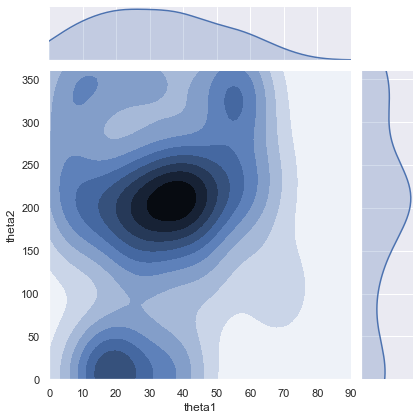

In [100]:
XLIM = [0,90]
YLIM = [0,360]

sns.jointplot(x='theta1',y='theta2', data=df.loc[:100], kind='kde', xlim=XLIM, ylim=YLIM) 

In [101]:
max_angle = 1.2*max_angle_from_obj

num_along_dim = 100
var1 = np.linspace(-90, 90, num=num_along_dim)
var2 = np.linspace(-90, 90, num=num_along_dim)

grid_var1, grid_var2 = np.meshgrid(var1, var2)
positions = np.vstack([grid_var1.flatten(), grid_var2.flatten()])
# print(positions)

def get_data(ii=0):
    bin_array = np.logical_and(time_mets>=time_bin_start_samp[ii], time_mets<=time_bin_end_samp[ii])
    if np.sum(bin_array) >= 3:
        data = df.loc[bin_array]
        x = data['theta1'].values
        y = data['theta2'].values
        return np.array([x,y]), 1
    else:
        return np.array([0,0]), 0

num_bins_analyze = num_samp_bins
photon_grid = np.zeros([num_bins_analyze, num_along_dim, num_along_dim])
for ii in range(0,num_bins_analyze):
    bin_photons, is_points = get_data(ii)
    if is_points == 1:
        num_photons = bin_photons.shape[1]
#         print(bin_photons)

        gkde = gaussian_kde(bin_photons, bw_method=0.3)
        pdf = gkde.evaluate(positions)
        photon_grid[ii] = num_photons*pdf.reshape([num_along_dim,num_along_dim])
    else:
        continue

all_photons = np.array([df['theta1'].values, df['theta2'].values])
# all_y = df['dDE'].values
num_photons = total_events
gkde = gaussian_kde(all_photons, bw_method=0.1)
pdf = gkde.evaluate(positions)
all_photon_grid = num_photons*pdf.reshape([num_along_dim,num_along_dim])

# print(photon_grid)
    
# num_points = get_data().shape[1]
# # print(get_data().T)
# gkde = gaussian_kde(get_data(), bw_method=0.3)

# pdf = gkde.evaluate(positions)
# # print(blah*num_points)


In [102]:
''' Finding power at 53-days '''

num_freq = 10
period = np.linspace(52, 54, num=num_freq)
freq = 1/period

power_array = np.zeros([num_along_dim, num_along_dim, num_freq])
power_array_max = np.zeros([num_along_dim, num_along_dim])
power_array_period = np.zeros([num_along_dim, num_along_dim])
power_array_phase = np.zeros([num_along_dim, num_along_dim])
for ii in range(0,num_along_dim):
    for jj in range(0,num_along_dim):
#         print(time_bin_samp_days.shape, photon_grid[:,ii,jj].shape)
#         blah = LombScargle(time_bin_samp_days[:num_bins_analyze], photon_grid[:,ii,jj]).power(freq)
        LS = LombScargle(time_bin_samp_days[:num_bins_analyze], photon_grid[:,ii,jj])
        power_array[ii,jj] = LS.power(freq)
        power_array_max[ii,jj] = np.max(power_array[ii,jj])
        power_array_period[ii,jj] = period[np.argmax(power_array[ii,jj])]
        model_params = LS.model_parameters(1/power_array_period[ii,jj])
        power_array_phase[ii,jj] = np.arctan(model_params[2]/model_params[1])
    
# power_array = np.max(power_array,axis=-1)
# print(power_array_period)
# print(power_array_phase)

exposure_power_array = LombScargle(time_bin_samp_days[:num_bins_analyze], exposure_bin_samp[:num_bins_analyze]).power(freq)
exposure_power = np.max(exposure_power_array)
expo_power_freq = period[np.argmax(exposure_power_array)]
print('Exposure Power array: '+str(exposure_power_array))
print('Exposure Power array max period: '+str(expo_power_freq))

counts_power_array = LombScargle(time_bin_samp_days[:num_bins_analyze], counts_bin_samp[:num_bins_analyze]).power(freq)
counts_power = np.max(counts_power_array)
counts_power_freq = period[np.argmax(counts_power_array)]
print('Counts Power array: '+str(counts_power_array))
print('Counts Power array max period: '+str(expo_power_freq))

[[53.33333333 53.33333333 53.33333333 ... 53.77777778 53.77777778
  53.55555556]
 [53.33333333 53.33333333 53.33333333 ... 53.77777778 53.55555556
  53.55555556]
 [53.33333333 53.33333333 53.33333333 ... 53.55555556 53.55555556
  53.55555556]
 ...
 [53.33333333 53.33333333 53.33333333 ... 53.55555556 53.55555556
  53.55555556]
 [53.33333333 53.33333333 53.33333333 ... 53.55555556 53.55555556
  53.55555556]
 [53.33333333 53.33333333 53.33333333 ... 53.55555556 53.55555556
  53.55555556]]
[[-1.37724703 -1.40451702 -1.43357467 ... -1.01138877 -1.00552209
  -1.54364511]
 [-1.37803755 -1.40437814 -1.4330611  ... -1.03872197  1.5668572
  -1.56065925]
 [-1.37982781 -1.40534155 -1.43367582 ...  1.5350724   1.55125565
   1.55776539]
 ...
 [-1.37836342 -1.38285278 -1.38248061 ...  1.13447461  1.11588954
   1.09815765]
 [-1.37505133 -1.37824188 -1.37771646 ...  1.13343527  1.11477421
   1.09721254]
 [-1.37270666 -1.37480618 -1.37455645 ...  1.13433108  1.11551725
   1.09804086]]
Exposure Power ar

In [104]:
''' Plotting power '''
###
### PLOT
###
font = {'family' : 'serif',
		'weight' : 'normal',
		'size'   : 12}

matplotlib.rc('font', **font)

cmap2 = plt.get_cmap('gist_stern_r')
cmap  = plt.get_cmap('Greys')#'gnuplot2')#'BuPu_r')
fig = plt.figure()

gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0,0])

for axis in ['top','bottom','left','right']:
	ax0.spines[axis].set_linewidth(1)
ax0.tick_params(which='major',width=0.5, length=8, labelsize='small', direction='in')
ax0.tick_params(which='minor',width=0.25, length=5, direction='in')

grid_dist = (grid_var1**2 + grid_var2**2)**0.5
in_roi = grid_dist < bin_roi

# max_power = np.max(power_array[in_roi])
# min_power = np.min(power_array[in_roi])
# LEVELS = np.linspace(min_power, max_power, num=21)

# power_array_masked = np.ma.masked_where(in_roi == False, power_array)

CF1 = ax0.contourf(grid_var1, grid_var2, power_array_max, cmap=cmap2, levels=30, zorder=9)
EXPO = ax0.contour(grid_var1, grid_var2, power_array_max, colors='r', levels=[exposure_power], zorder=10)

cbar = fig.colorbar(CF1)
cbar.set_label('Power at 53 days')

C1 = ax0.contour(grid_var1, grid_var2, all_photon_grid, levels=10, cmap=cmap, zorder=9.5)

# ax0.set_aspect('equal')
ax0.text(0.05, 0.95, 'Exposure Power = '+str(round(exposure_power,4)), transform=ax0.transAxes, verticalalignment='center', horizontalalignment='left', zorder=11)
ax0.text(0.05, 0.05, 'Counts Power = '+str(round(counts_power,4)), transform=ax0.transAxes, verticalalignment='center', horizontalalignment='left', zorder=11)

ax0.set_xlabel('Theta1 [deg]')
ax0.set_ylabel('Theta2 [deg]')


# plt.show()

plot_name = './instrumental/map_photon_power_'+object+'_e'+str(ebin_number)+'_'
for n in range(0,100):
	if os.path.isfile(plot_name+str(n).zfill(2)+'.png'):
		continue
	else:
		plt.savefig(plot_name+str(n).zfill(2)+'.png', bbox_inches='tight', dpi=400)
		break
plt.close()


C:\Users\psyko\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: No contour levels were found within the data range.


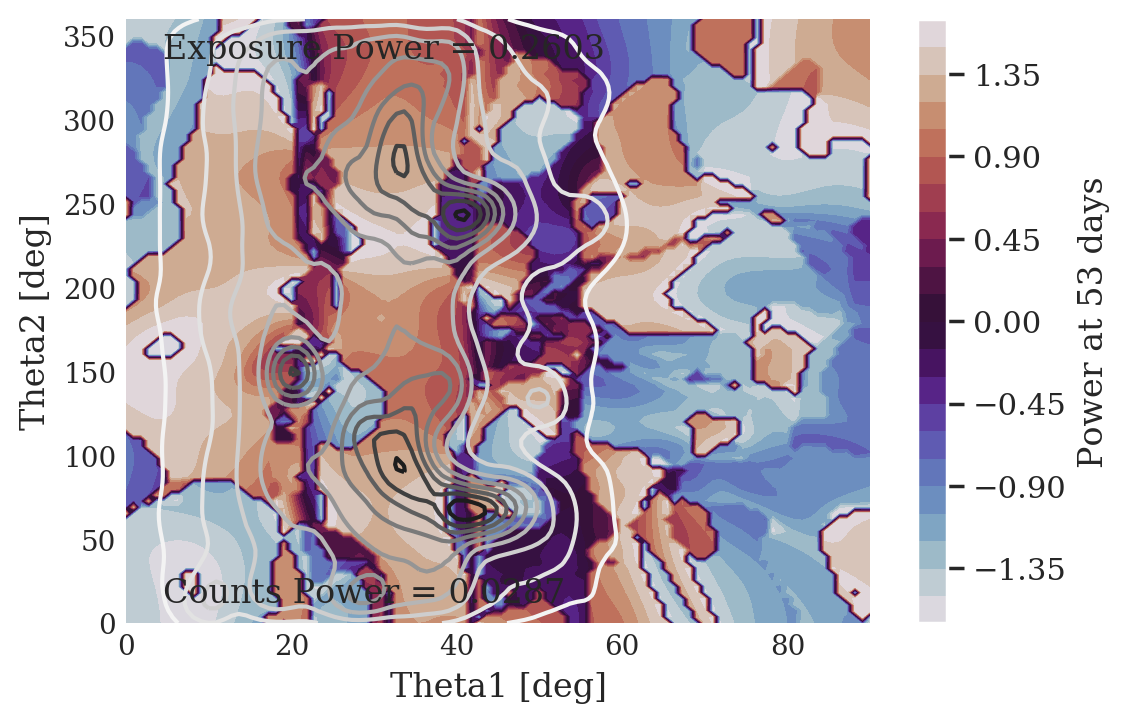

In [105]:
''' Plotting power '''
###
### PLOT
###
font = {'family' : 'serif',
		'weight' : 'normal',
		'size'   : 12}

matplotlib.rc('font', **font)

cmap2 = plt.get_cmap('twilight')
cmap  = plt.get_cmap('Greys')#'gnuplot2')#'BuPu_r')
fig = plt.figure(dpi=200)

gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0,0])

for axis in ['top','bottom','left','right']:
	ax0.spines[axis].set_linewidth(1)
ax0.tick_params(which='major',width=0.5, length=8, labelsize='small', direction='in')
ax0.tick_params(which='minor',width=0.25, length=5, direction='in')

grid_dist = (grid_var1**2 + grid_var2**2)**0.5
in_roi = grid_dist < bin_roi

# max_power = np.max(power_array[in_roi])
# min_power = np.min(power_array[in_roi])
# LEVELS = np.linspace(min_power, max_power, num=21)

# power_array_masked = np.ma.masked_where(in_roi == False, power_array)

CF1 = ax0.contourf(grid_var1, grid_var2, power_array_phase, cmap=cmap2, levels=30, zorder=9)
# EXPO = ax0.contour(grid_var1, grid_var2, power_array, colors='r', levels=[exposure_power], zorder=10)

cbar = fig.colorbar(CF1)
cbar.set_label('Phase at 53 days')

C1 = ax0.contour(grid_var1, grid_var2, all_photon_grid, levels=10, cmap=cmap, zorder=9.5)

# ax0.set_aspect('equal')
ax0.text(0.05, 0.95, 'Exposure Power = '+str(round(exposure_power,4)), transform=ax0.transAxes, verticalalignment='center', horizontalalignment='left', zorder=11)
ax0.text(0.05, 0.05, 'Counts Power = '+str(round(counts_power,4)), transform=ax0.transAxes, verticalalignment='center', horizontalalignment='left', zorder=11)

ax0.set_xlabel('Theta1 [deg]')
ax0.set_ylabel('Theta2 [deg]')


# plt.show()

# plot_name = './instrumental/map_photon_power_'+object+'_e'+str(ebin_number)+'_'
# for n in range(0,100):
# 	if os.path.isfile(plot_name+str(n).zfill(2)+'.png'):
# 		continue
# 	else:
# 		plt.savefig(plot_name+str(n).zfill(2)+'.png', bbox_inches='tight', dpi=400)
# 		break
# plt.close()


______________________________________________

Energy analysis

[4.04000000e+04 1.34666667e+04 8.08000000e+03 ... 1.99792295e+00
 1.99772536e+00 1.99752781e+00] [4.12487148e-02 4.06768955e-02 3.94032971e-02 ... 3.77970585e-05
 2.66658616e-06 6.51372347e-05]
37.03024747937671 0.07332618008152643
36.962488563586454 0.06518756166268398
36.962488563586454 0.07105576794832419
36.962488563586454 0.055896691424090456
36.962488563586454 0.04303818494752172
46.38346727898966 0.04363937367033409
52.9488859764089 0.04519681651725024
53.08804204993429 0.048009967413401
53.08804204993429 0.0500967161123262
53.08804204993429 0.05117615057942393
53.08804204993429 0.051452264641190244
53.08804204993429 0.05106419291915874
53.08804204993429 0.04966446245546534
53.08804204993429 0.04691306349508131
53.08804204993429 0.04302315186932061
52.9488859764089 0.03886550076978906
52.9488859764089 0.035404735956407446
52.9488859764089 0.03232894482728655
52.9488859764089 0.030006313371626094
52.81045751633986 0.028682203133854032
52.81045751633986 0.028358499446763944
52.810

(10, 100)

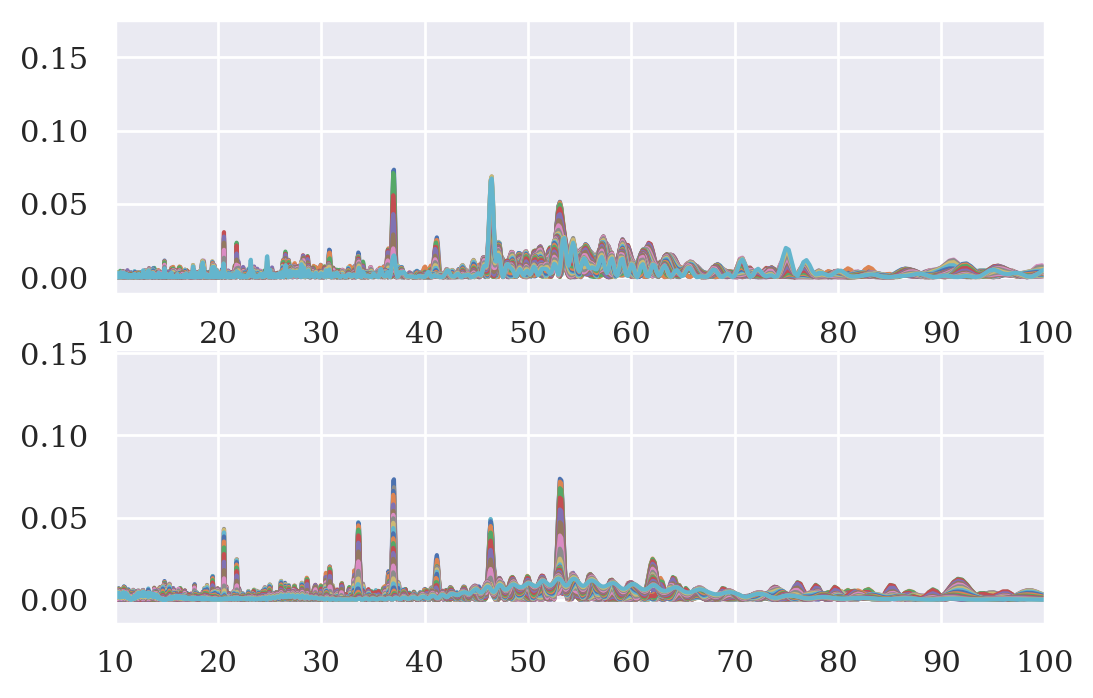

In [137]:
''' Finding power at 53-days '''

num_freq = 100
period = np.linspace(52, 54, num=num_freq)
freq = 1/period

# power_array = np.zeros([num_along_dim, num_along_dim, num_freq])
# power_array_max = np.zeros([num_along_dim, num_along_dim])
# power_array_period = np.zeros([num_along_dim, num_along_dim])
# power_array_phase = np.zeros([num_along_dim, num_along_dim])
# for ii in range(0,num_along_dim):
#     for jj in range(0,num_along_dim):
#         print(time_bin_samp_days.shape, photon_grid[:,ii,jj].shape)
#         blah = LombScargle(time_bin_samp_days[:num_bins_analyze], photon_grid[:,ii,jj]).power(freq)

freq_pa, expo_pa = LombScargle(time_bin_samp_days[:num_bins_analyze], exposure_bin_samp[:num_bins_analyze]).autopower()

print(1/freq_pa, expo_pa)


fig = plt.figure(dpi=200)
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])

# ax0.plot(1/freq_pa,expo_pa, color='k')

ii0 = 50
jj = 50

for ii in range(0,40):

    LS = LombScargle(time_bin_samp_days[:num_bins_analyze], photon_grid[:,ii0+ii,jj])
    frequency, power_array_point = LS.autopower()

    freq1 = frequency[np.logical_and(1/frequency>10, 1/frequency<300)]
    power1 = power_array_point[np.logical_and(1/frequency>10, 1/frequency<300)]
    print(1/freq1[np.argmax(power1)], np.max(power1))

    ax0.plot(1/frequency,power_array_point)

for ii in range(0,40):

    LS = LombScargle(time_bin_samp_days[:num_bins_analyze], photon_grid[:,ii0,jj+ii])
    frequency, power_array_point = LS.autopower()

    freq1 = frequency[np.logical_and(1/frequency>10, 1/frequency<300)]
    power1 = power_array_point[np.logical_and(1/frequency>10, 1/frequency<300)]
    print(1/freq1[np.argmax(power1)], np.max(power1))

    ax1.plot(1/frequency,power_array_point)
    
    
ax0.set_xlim([10,100])
ax1.set_xlim([10,100])
# ax0.set_xscale('log')
#         power_array_max[ii,jj] = np.max(power_array[ii,jj])
#         power_array_period[ii,jj] = period[np.argmax(power_array[ii,jj])]
#         model_params = LS.model_parameters(1/power_array_period[ii,jj])
#         power_array_phase[ii,jj] = np.arctan(model_params[2]/model_params[1])
    
# power_array = np.max(power_array,axis=-1)
# print(power_array_period)
# print(power_array_phase)

